In [9]:
import math
import torch
from inspect import isfunction
from functools import partial
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:

def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

def extract(a, t, x_shape=(1,1,1)):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

# beta_schedule function
def _warmup_beta(linear_start, linear_end, n_timestep, warmup_frac):
    betas = linear_end * np.ones(n_timestep, dtype=np.float64)
    warmup_time = int(n_timestep * warmup_frac)
    betas[:warmup_time] = np.linspace(
        linear_start, linear_end, warmup_time, dtype=np.float64)
    return betas

def make_beta_schedule(schedule, n_timestep, linear_start=1e-6, linear_end=1e-2, cosine_s=8e-3):
    if schedule == 'quad':
        betas = np.linspace(linear_start ** 0.5, linear_end ** 0.5,
                            n_timestep, dtype=np.float64) ** 2
    elif schedule == 'linear':
        betas = np.linspace(linear_start, linear_end,
                            n_timestep, dtype=np.float64)
    elif schedule == 'warmup10':
        betas = _warmup_beta(linear_start, linear_end,
                             n_timestep, 0.1)
    elif schedule == 'warmup50':
        betas = _warmup_beta(linear_start, linear_end,
                             n_timestep, 0.5)
    elif schedule == 'const':
        betas = linear_end * np.ones(n_timestep, dtype=np.float64)
    elif schedule == 'jsd':  # 1/T, 1/(T-1), 1/(T-2), ..., 1
        betas = 1. / np.linspace(n_timestep,
                                 1, n_timestep, dtype=np.float64)
    elif schedule == "cosine":
        timesteps = (
            torch.arange(n_timestep + 1, dtype=torch.float64) /
            n_timestep + cosine_s
        )
        alphas = timesteps / (1 + cosine_s) * math.pi / 2
        alphas = torch.cos(alphas).pow(2)
        alphas = alphas / alphas[0]
        betas = 1 - alphas[1:] / alphas[:-1]
        betas = betas.clamp(max=0.999)
    else:
        raise NotImplementedError(schedule)
    return betas


def q_sample( y_0, sample_gammas, noise=None):
    noise = default(noise, lambda: torch.randn_like(y_0))
    return (
        sample_gammas.sqrt() * y_0 +
        (1 - sample_gammas).sqrt() * noise
    )

In [3]:
def forward(y_0,gammas,num_timesteps = 2000, y_cond=None, mask=None, noise=None):
    # sampling from p(gammas)
    b, *_ = y_0.shape

    t = torch.randint(1, num_timesteps, (b,), device=y_0.device).long()
    gamma_t1 = extract(gammas, t-1, x_shape=(1,))
    sqrt_gamma_t2 = extract(gammas, t, x_shape=(1,))
    sample_gammas = (sqrt_gamma_t2-gamma_t1) * torch.rand((b,), device=y_0.device) + gamma_t1
    sample_gammas = sample_gammas.view(b, -1)

    noise = default(noise, lambda: torch.randn_like(y_0))
    y_noisy =q_sample(
        y_0=y_0, sample_gammas=sample_gammas.view(-1, 1, 1), noise=noise)
    return y_noisy

In [4]:
num_timesteps = 2000
schedule=''
betas = make_beta_schedule(schedule=schedule,n_timestep=num_timesteps,linear_end=0.01,linear_start=1e-6,cosine_s=0.008)
alphas = 1. - betas
gammas = np.cumprod(alphas, axis=0)


NotImplementedError: 

In [6]:
DATA_DIR = r"F:\minowa\BloodPressureEstimation\data\processed\BP_npy\0125_align_norm\p00\validate.npy"
val = np.load(DATA_DIR)
val.shape

(33155, 512, 2)

(33149, (512, 2))

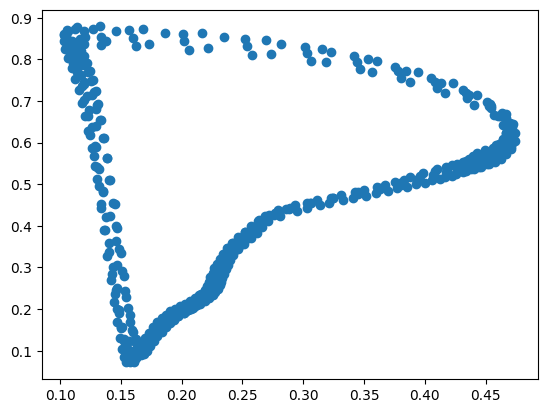

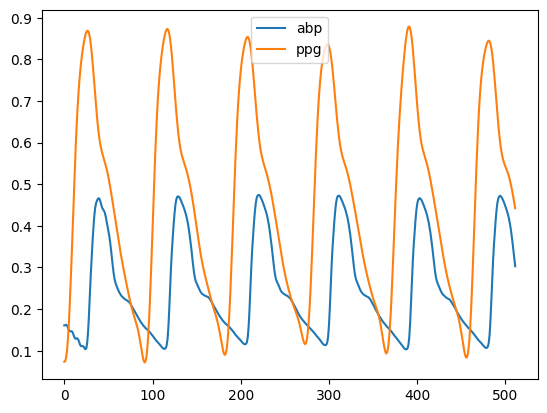

In [53]:
i = np.random.randint(len(val))
i =33149
t = val[i]
plt.scatter(t[:,0],t[:,1],label='abp')
plt.figure()
plt.plot(t[:,0],label='abp')
plt.plot(t[:,1],label='ppg')
plt.legend()
i,t.shape

In [43]:
import pandas as pd
a = []
for i in tqdm(range(len(val))):
    s1 = pd.Series(val[i][:,0])
    s2 = pd.Series(val[i][:,1])
    r = s1.corr(s2)
    a.append(r)

100%|██████████| 33155/33155 [00:03<00:00, 9542.70it/s]


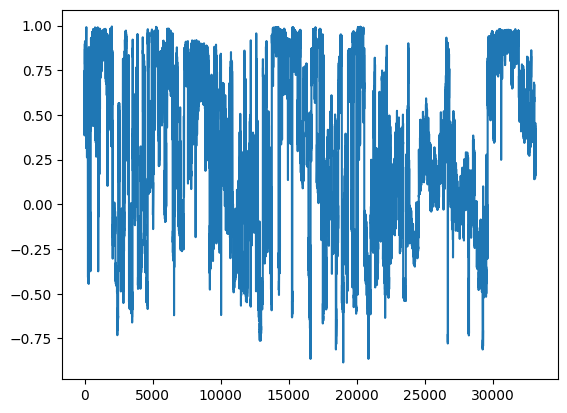

In [44]:
plt.plot(a)

In [49]:
np.where(np.array(a)<0.25)

(array([  240,   241,   242, ..., 33149, 33150, 33151], dtype=int64),)

In [46]:
np.array(a).mean()

0.32034404485428863